# Setup

In [1]:
#Libreries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm 
import statsmodels.api as sm
import seaborn as sns
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the CSV file
online_retail = pd.read_csv('Online Retail.csv', encoding_errors='ignore')

# Convert the date column to datetime format
online_retail['InvoiceDate'] = pd.to_datetime(online_retail['InvoiceDate'])

# Add the day of the week in the format 'ddd' (e.g., 'Mon', 'Tue', etc.)
online_retail['Day of the Week'] = online_retail['InvoiceDate'].dt.day_name()
online_retail['Month'] = online_retail['InvoiceDate'].dt.month_name()

#Separted Date and Time
online_retail['InvoiceTime'] = online_retail['InvoiceDate'].dt.time
online_retail['InvoiceDate'] = online_retail['InvoiceDate'].dt.date

# Add Cancel column to identify is invoice has been cancelled
online_retail['Cancelled'] = online_retail['InvoiceNo'][0] == 'C'
online_retail

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Day of the Week,Month,InvoiceTime,Cancelled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,Wednesday,December,08:26:00,False
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,Wednesday,December,08:26:00,False
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,Wednesday,December,08:26:00,False
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,Wednesday,December,08:26:00,False
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,Wednesday,December,08:26:00,False
...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09,0.85,12680.0,France,Friday,December,12:50:00,False
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09,2.10,12680.0,France,Friday,December,12:50:00,False
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09,4.15,12680.0,France,Friday,December,12:50:00,False
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09,4.15,12680.0,France,Friday,December,12:50:00,False


# Median Expenses per Country

## Data Cleanup

In [3]:
data = online_retail

In [4]:
# List nulls
data.isnull().sum()

InvoiceNo               0
StockCode               0
Description          1454
Quantity                0
InvoiceDate             0
UnitPrice               0
CustomerID         135080
Country                 0
Day of the Week         0
Month                   0
InvoiceTime             0
Cancelled               0
dtype: int64

In [5]:
# List duplicates
data.duplicated().sum()

5268

In [6]:
# Remove duplicates
data.drop_duplicates(inplace=True)

## Show Median Expenses per Country

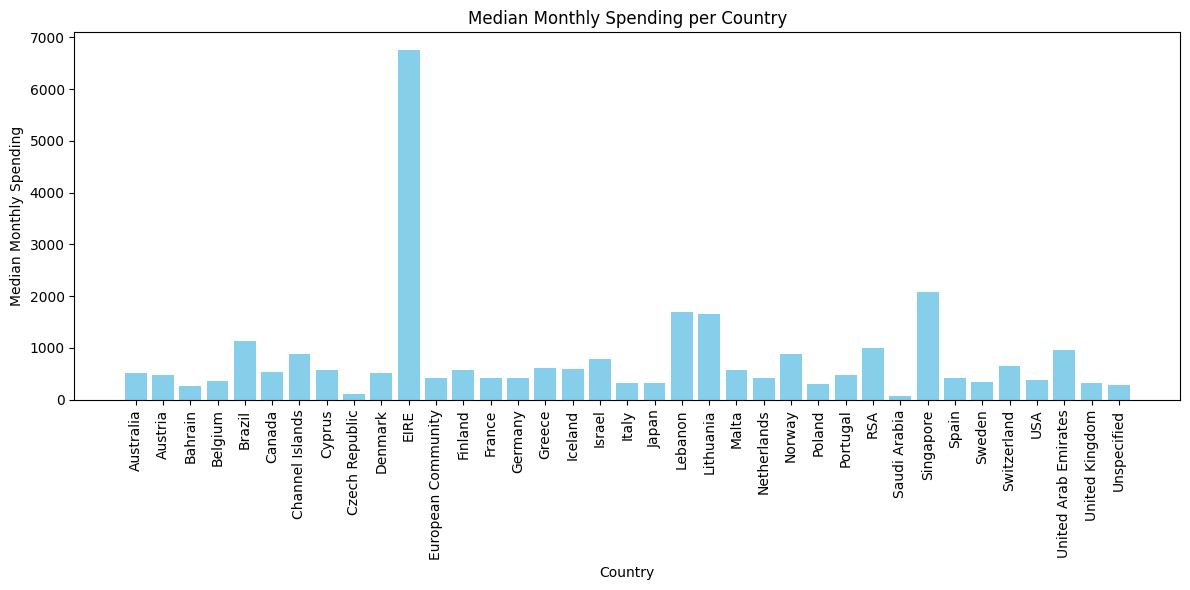

In [7]:
#  InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Add a column for the total price
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

# Extract year and month from InvoiceDate
data['YearMonth'] = data['InvoiceDate'].dt.to_period('M')

# Group by CustomerID, YearMonth, and Country, then sum the TotalPrice
monthly_spending = data.groupby(['CustomerID', 'YearMonth', 'Country'])['TotalPrice'].sum().reset_index()

# Get the median spending per month for each country
median_spending = monthly_spending.groupby('Country')['TotalPrice'].median().reset_index()

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.bar(median_spending['Country'], median_spending['TotalPrice'], color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Median Monthly Spending')
plt.title('Median Monthly Spending per Country')
plt.tight_layout()
plt.show()

# Per Country Whiskerplot and Multi Linear Regression

## Pre-Processing

In [8]:
# List countries
online_retail['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [9]:
# Dropping 'Unspecified', 'European Community'
online_retail = online_retail[~online_retail['Country'].isin(('Unspecified', 'European Community'))]

In [10]:
# Drop Description
online_retail.drop('Description', axis='columns', inplace=True)

In [11]:
# Calculate 'Total' column
online_retail['Total'] = online_retail['UnitPrice'] * online_retail['Quantity']

## Whisker Plot

In [12]:
# Group
group_customers = online_retail.groupby(['InvoiceNo', 'CustomerID', 'InvoiceDate', 'InvoiceTime', 'Country', 'Day of the Week','Cancelled','Month'], group_keys=True)[['Country','Total', 'Quantity']].sum(lambda x: x)

In [13]:
# Clean up data, remove extremelly expensive orders and cancels
df = group_customers
filtered_df = df[(df['Total'] <= 4000) & (df['Total'] >= 0)]

In [14]:
# Describe
filtered_df.groupby('Country')['Total'].describe()

,count,mean,std,min,25%,50%,75%,max
Country,,,,,,,,
Australia,49.0,480.447551,543.165274,61.20,158.6500,375.240,521.5000,2735.16
Austria,17.0,599.922353,388.077177,153.76,277.2000,534.700,742.9300,1542.08
Bahrain,2.0,274.200000,261.912352,89.00,181.6000,274.200,366.8000,459.40
Belgium,98.0,420.370816,286.121729,34.00,225.7750,346.390,544.6400,1491.59
Brazil,1.0,1143.600000,NaN,1143.60,1143.6000,1143.600,1143.6000,1143.60
Canada,6.0,611.063333,495.163105,51.56,238.9650,542.590,1016.3300,1217.64
Channel Islands,26.0,786.174615,571.004629,33.00,269.4875,717.570,1104.9025,2060.03
Cyprus,16.0,843.928125,777.990282,15.00,289.6050,573.945,1228.7575,2814.30
Czech Republic,2.0,413.370000,192.177481,277.48,345.4250,413.370,481.3150,549.26


<Axes: xlabel='Total', ylabel='Country'>

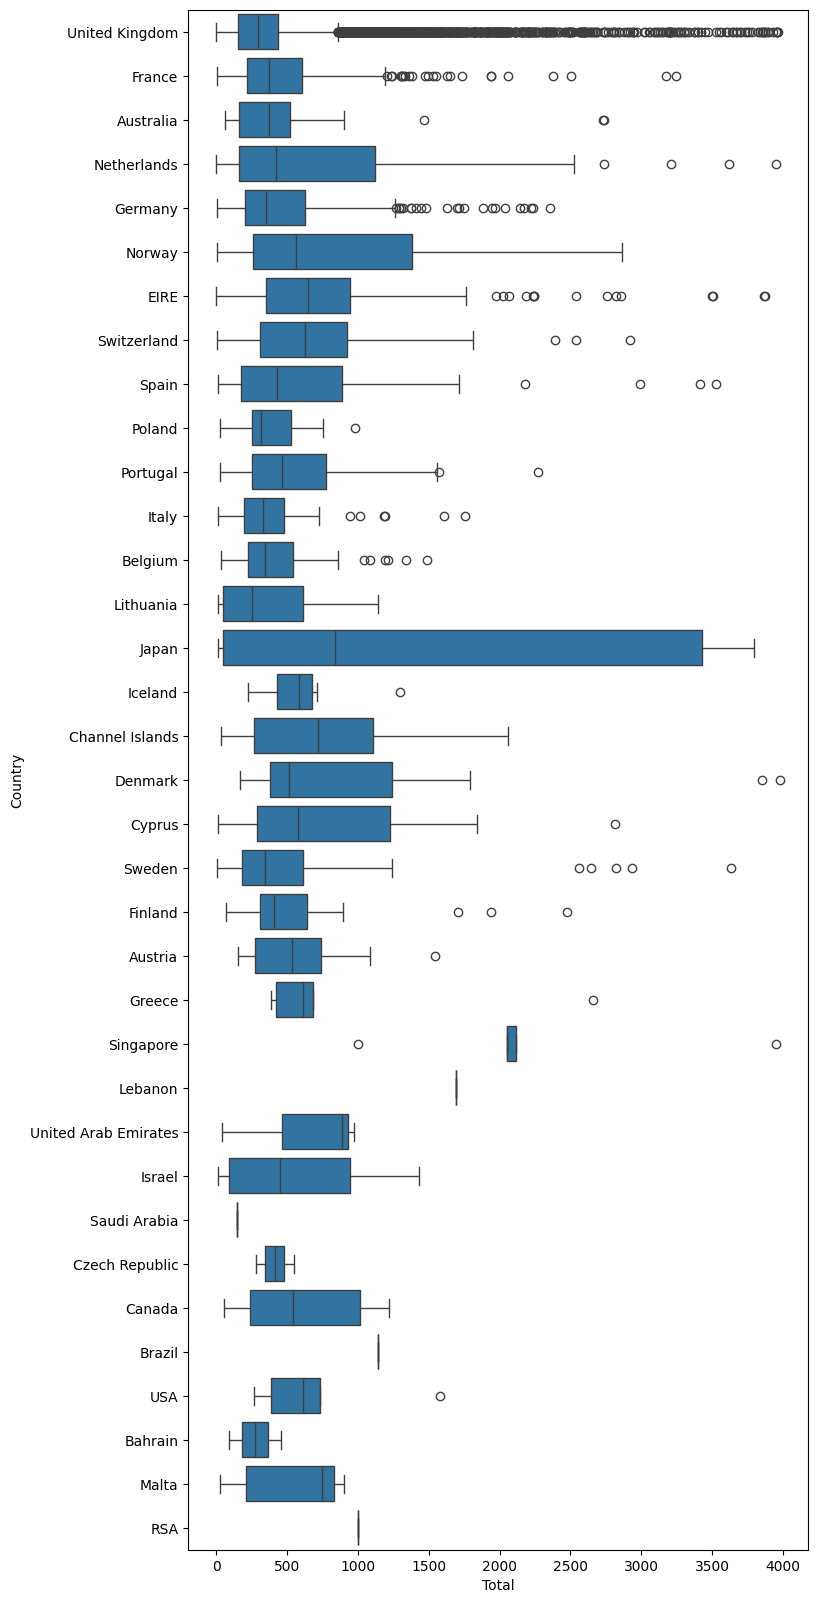

In [15]:
# Plot
plt.figure(figsize=(8, 20))
sns.boxplot(x = 'Total', y = 'Country', data = filtered_df, orient = 'h')

## Multiple Linear Regression

In [16]:
# With this section, we will study how the day of the week and the month influence the total daily expenses

### One Hot Encoding

In [17]:
# Group Total expending by Day and Month
g_c = group_customers.reset_index()
group_month_day = g_c.groupby(['InvoiceDate','Day of the Week', 'Month'],group_keys=True)[['Total']].sum(lambda x: x)
group_month_day = group_month_day.reset_index()
# One Hot Encoding
one_hot_online_retail = pd.get_dummies(group_month_day.reset_index(), columns=['Day of the Week', 'Month'], dtype=float)
one_hot_online_retail.columns

Index(['index', 'InvoiceDate', 'Total', 'Day of the Week_Friday',
       'Day of the Week_Monday', 'Day of the Week_Sunday',
       'Day of the Week_Thursday', 'Day of the Week_Tuesday',
       'Day of the Week_Wednesday', 'Month_April', 'Month_August',
       'Month_December', 'Month_February', 'Month_January', 'Month_July',
       'Month_June', 'Month_March', 'Month_May', 'Month_November',
       'Month_October', 'Month_September'],
      dtype='object')

### Fit Multiple Linear Regression

In [18]:
import statsmodels.api as sm

X = one_hot_online_retail[[column for column in one_hot_online_retail.columns if column.startswith('Day of the Week') or column.startswith('Month')]]
y = one_hot_online_retail['Total']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

In [19]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Total   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     15.74
Date:                Sun, 23 Jun 2024   Prob (F-statistic):           7.92e-31
Time:                        06:55:37   Log-Likelihood:                -3262.3
No. Observations:                 305   AIC:                             6559.
Df Residuals:                     288   BIC:                             6622.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      2.141e+04    505.667     42.349      0.000    2.04e+04    2.24e+04
Day of the Week_Friday     1248.1728   1422.624      0.877      0.381   -1551.886    4048.232
Day of the Week_Monday     3420.3297   1460.917      2.341      0.020     544.902    6295.757
Day of the Week_Sunday    -7927.9414   1423.178     -5.571      0.000   -1.07e+04   -5126.792
Day of the Week_Thursday   1.251e+04   1388.547      9.012      0.000    9780.986    1.52e+04
Day of the Week_Tuesday    6706.2873   1399.505      4.792      0.000    3951.733    9460.842
Day of the Week_Wednesday  5453.5128   1387.769      3.930      0.000    2722.057    8184.969
Month_April               -5423.1262   2284.568     -2.374      0.018   -9919.694    -926.558
Month_August              -1540.1076   2069.236     -0.744      0.457   -5612.850    2532.635
Month_December             6318.7117   2001.360      3.157      0.002    2379.565    1.03e+04
Month_February            -6836.1382   2146.320     -3.185      0.002   -1.11e+04   -2611.675
Month_January             -5244.5620   2146.320     -2.444      0.015   -9469.025   -1020.099
Month_July                -2465.6519   2069.970     -1.191      0.235   -6539.839    1608.535
Month_June                -2082.4752   2069.130     -1.006      0.315   -6155.009    1990.058
Month_March               -4071.9244   2033.556     -2.002      0.046   -8074.442     -69.407
Month_May                  1191.4100   2108.276      0.565      0.572   -2958.173    5340.994
Month_November             1.816e+04   2069.236      8.777      0.000    1.41e+04    2.22e+04
Month_October               1.29e+04   2070.422      6.230      0.000    8824.305     1.7e+04
Month_September            1.051e+04   2069.561      5.077      0.000    6432.926    1.46e+04
==============================================================================
Omnibus:                       91.577   Durbin-Watson:                   1.796
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              373.018
Skew:                           1.217   Prob(JB):                     1.00e-81
Kurtosis:                       7.840   Cond. No.                     5.86e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.11e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [20]:
# Create dataframe with inputs for model
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday']
months_of_year = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

from itertools import product

df = pd.DataFrame([{'const': 1, 'Day of the Week': day, 'Month': month} for day, month in product(days_of_week, months_of_year)])
df_oh = pd.get_dummies(df, columns=['Day of the Week', 'Month'], dtype=float)

In [21]:
# Predict
prediction = model.predict(df_oh)

In [22]:
# Prepare result for plotting
result = df.drop(columns=['const'])
result['Prediction'] = prediction

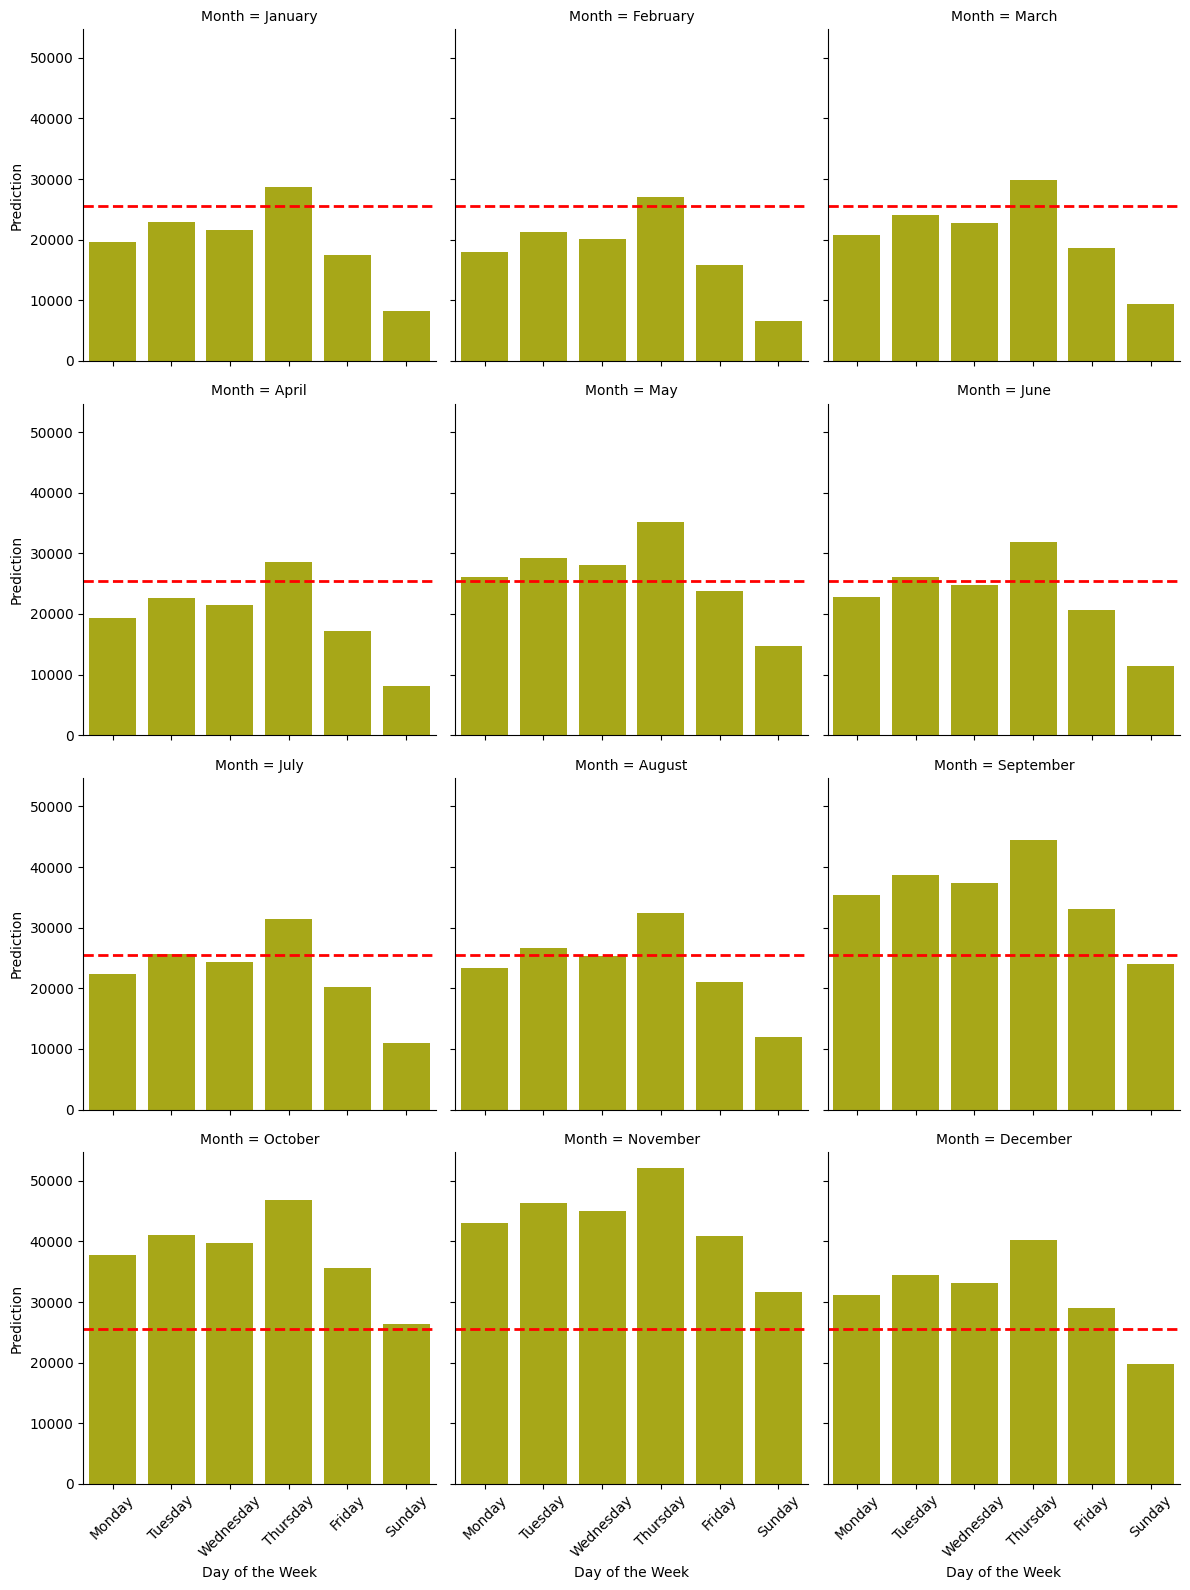

In [23]:
# Facet Grid Plot
g = sns.FacetGrid(result, col='Month', col_wrap=3, height=4)
g.map(sns.barplot, 'Day of the Week', 'Prediction', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday'], color='y')

# Rotate X labels
for ax in g.axes.flat:
    ax.axhline(result['Prediction'].median(), color='red', linestyle='--', lw=2)
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

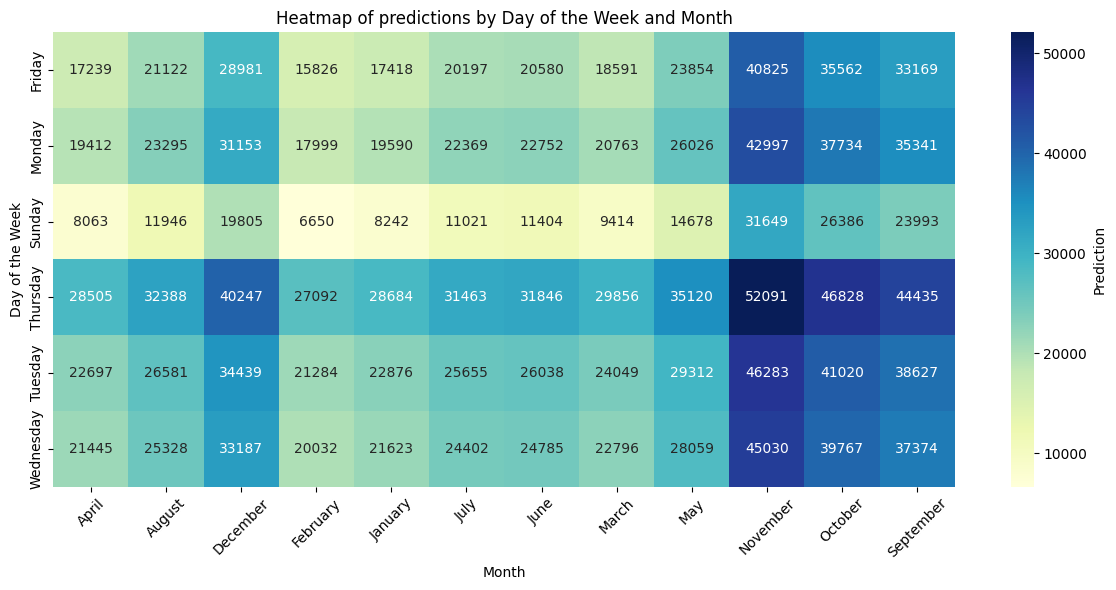

In [24]:
# Draw as heatmap
heatmap_data = result.pivot(index='Day of the Week', columns='Month', values='Prediction')

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlGnBu', cbar_kws={'label': 'Prediction'})

# Rotate X labels
plt.xticks(rotation=45)
plt.title('Heatmap of predictions by Day of the Week and Month')
plt.xlabel('Month')
plt.ylabel('Day of the Week')

plt.tight_layout()
plt.show()
